# PBRM1 proteomics cis comparison

"Involved in transcriptional activation and repression of select genes by chromatin remodeling (alteration of DNA-nucleosome topology). Required for the stability of the SWI/SNF chromatin remodeling complex SWI/SNF-B (PBAF). Acts as a negative regulator of cell proliferation (https://www.uniprot.org/uniprot/Q86U86).

## Step 1: Library Imports

Run this cell to import the necessary libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
sys.path.append('C:\\Users\\brittany henderson\\GitHub\\WhenMutationsMatter\\Brittany\\')
import functions as f

import cptac
import cptac.algorithms as al

## Step 2: Find the frequently mutated genes for Kidney Cancer

Enter the type of cancer and the cutoff for mutation frequency that you would like to use.

In [3]:
rc_object = cptac.RenalCcrcc()
desired_cutoff = 0.1

renal_freq_mut = al.get_frequently_mutated(rc_object, cutoff = desired_cutoff)
renal_freq_mut.loc[renal_freq_mut['Gene'] == 'PBRM1']

,Gene,Unique_Samples_Mut,Missence_Mut,Truncation_Mut
2,PBRM1,0.4,0.072727,0.336364


## Step 3: Select PBRM1, a frequently mutated gene

In [4]:
gene = 'PBRM1'

## Step 4: Select proteomics

In [13]:
omics = rc_object.get_proteomics()

## Step 5: cis comparison 

Determine if the DNA mutation has an effect on the omics measurement. In order to do this, we have a few steps in code. These steps are found in the format_cis_comparison_data function.
1. get a table with both the omics and mutation data for tumors
2. get a binary column from the mutation data to separate our samples
3. format data frame to be used in the T-test
4. send data to the T-test.

The format_cis_comparison_data does the first 3 steps.

In [5]:
rc_status = f.format_cis_comparison_data(rc_object, 'proteomics', gene)

In [6]:
omics_col_list = [gene+'_proteomics']
prot_col = gene+"_proteomics"

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison\n")
significant_pval_results = al.wrap_ttest(rc_status, 'binary_mutations', omics_col_list)
print(significant_pval_results)

Doing t-test comparison

         Comparison       P_Value
0  PBRM1_proteomics  1.657330e-10


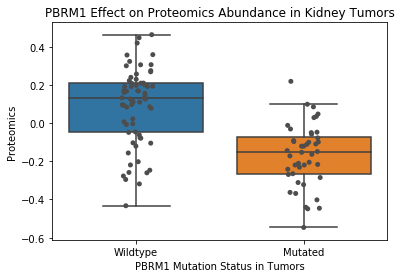

In [7]:
# Step 5 - Create boxplt to compare wildtype and mutated effect on omics data
cis_boxplot = sns.boxplot(data = rc_status, x = 'binary_mutations',
                          y = prot_col, order = ["Wildtype","Mutated"], showfliers = False)  
cis_boxplot.set_title(gene + " Effect on Proteomics Abundance in Kidney Tumors")
cis_boxplot = sns.stripplot(data= rc_status, x = 'binary_mutations',
                            y = prot_col,jitter = True, color = ".3", order = ["Wildtype","Mutated"])
cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()

PBRM1 proteomics decreased in the PBRM1 mutated samples compared to the wildtype.

Repeat the above steps this time comparing missence and truncation mutation types.

In [8]:
rc_type = f.get_missence_truncation_comparison(rc_object, 'proteomics', gene)

print("Doing t-test comparison\n")
significant_pval_results = al.wrap_ttest(rc_type, 'binary_mutations', omics_col_list)
print(significant_pval_results)
# ? not enough data?

Doing t-test comparison

No significant comparisons.
None


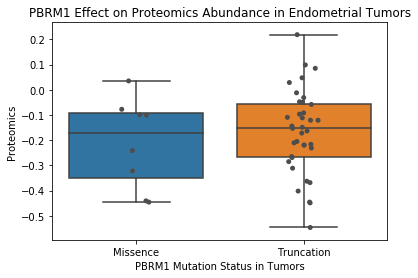

In [9]:
rc_cis_boxplot = sns.boxplot(data = rc_type, x = 'binary_mutations',
                          y = prot_col, order = ["Missence","Truncation"], showfliers = False)  
rc_cis_boxplot.set_title(gene + " Effect on Proteomics Abundance in Endometrial Tumors")
rc_cis_boxplot = sns.stripplot(data= rc_type, x = 'binary_mutations',
                            y = prot_col, jitter = True, color = ".3", order = ["Missence","Truncation"])
rc_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()

In [85]:
# Find common mutations
somatic_mutations = rc_object.get_mutations()
gene_mutations = somatic_mutations.loc[somatic_mutations['Gene'] == gene]
mutation_counts = gene_mutations['Mutation'].value_counts().to_frame()

# Make a list of common mutations 
cutoff = 9
filter_common_mutations = mutation_counts.loc[mutation_counts['Mutation'] > cutoff]
common_mutations_list = list(filter_common_mutations.index)

# get samples with common mutation, keep those
common_mutations_list


['Frame_Shift_Del', 'Nonsense_Mutation']

In [84]:
l = 'Nonsense_Mutation'
f = gene_mutations[['Mutation']].where(lambda x: x == 'Nonsense_Mutation').dropna()
samples_common_mut = f.index.unique()
samples_common_mut

                    Mutation
Sample_ID                   
S001       Nonsense_Mutation
S010       Nonsense_Mutation
S027       Nonsense_Mutation
S035       Nonsense_Mutation
S048       Nonsense_Mutation
S048       Nonsense_Mutation
S062       Nonsense_Mutation
S091       Nonsense_Mutation
S092       Nonsense_Mutation
S094       Nonsense_Mutation
S101       Nonsense_Mutation
S113       Nonsense_Mutation
S122       Nonsense_Mutation
S130       Nonsense_Mutation


Index(['S001', 'S010', 'S027', 'S035', 'S048', 'S062', 'S091', 'S092', 'S094',
       'S101', 'S113', 'S122', 'S130'],
      dtype='object', name='Sample_ID')

In [56]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest
omics_and_mut = rc_object.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'proteomics', omics_genes = gene)
common_mut = 'Nonsense_Mutation'
# Step 2 - Create the binary column needed to do the comparison
omics_and_mut['binary_mutations'] = omics_and_mut[gene+'_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else(common_mut if x == common_mut else omics_and_mut.drop(x,axis=0)))

#omics_and_mut.dropna(axis=0)

KeyError: "['Single_mutation'] not found in axis"

In [48]:
omics_col_list = [gene+'_proteomics']


['PBRM1_proteomics']

In [49]:
# T-test
print("Doing t-test comparison\n")
significant_pval_results = al.wrap_ttest(t, gene+'_Mutation', omics_col_list)
print(significant_pval_results)

Doing t-test comparison

         Comparison   P_Value
0  PBRM1_proteomics  0.000089


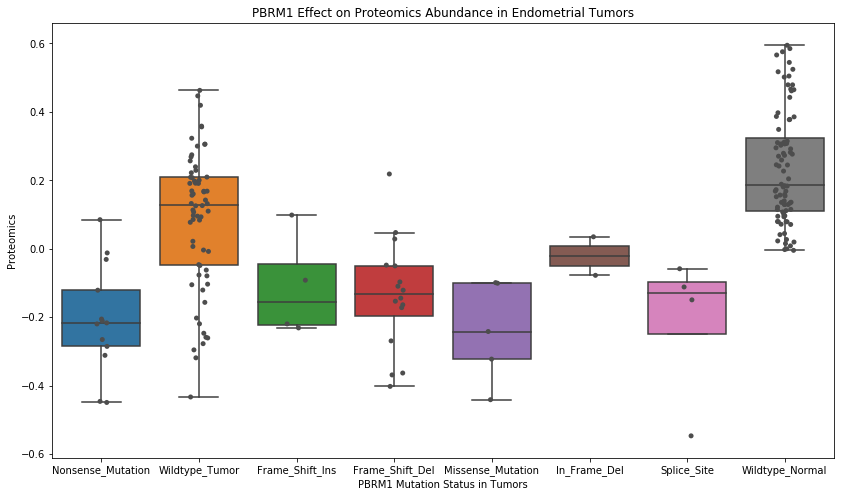

In [34]:
plt.rcParams['figure.figsize']=(14,8)
rc_cis_boxplot = sns.boxplot(data = filtered_mut, x = 'PBRM1_Mutation',
                          y = gene+'_proteomics', showfliers = False)  
rc_cis_boxplot.set_title(gene + " Effect on Proteomics Abundance in Endometrial Tumors")
rc_cis_boxplot = sns.stripplot(data= filtered_mut, x = 'PBRM1_Mutation',
                            y = gene+'_proteomics', jitter = True, color = ".3")
rc_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()

# Analysis of Results

PBRM1 proteomics decreased in the PBRM1 mutated samples compared to the wildtype.